## OLD SCHOOL MNIST WITH CONVOLUTIONAL NEURAL NETWORK
### M. ARUNWAT (Y. Shoichi)

In [1]:
import os
import math
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import tensorflow.keras as keras


In [2]:
sns.set()
print(f"Currently using Tensorflow {tf.__version__}")
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())
tf.random.set_seed(221)

Currently using Tensorflow 2.9.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


### DATA LOADER - DATA PREPROCESSING

In [3]:
train_mnist_images = idx2numpy.convert_from_file("Dataset/train-images.idx3-ubyte")
train_mnist_labels = idx2numpy.convert_from_file("Dataset/train-labels.idx1-ubyte")
test_mnist_images = idx2numpy.convert_from_file("Dataset/t10k-images.idx3-ubyte")
test_mnist_labels = idx2numpy.convert_from_file("Dataset/t10k-labels.idx1-ubyte")

[Text(0.5, 1.0, 'Test Labels Data'), Text(0.5, 0, 'Target 0-9')]

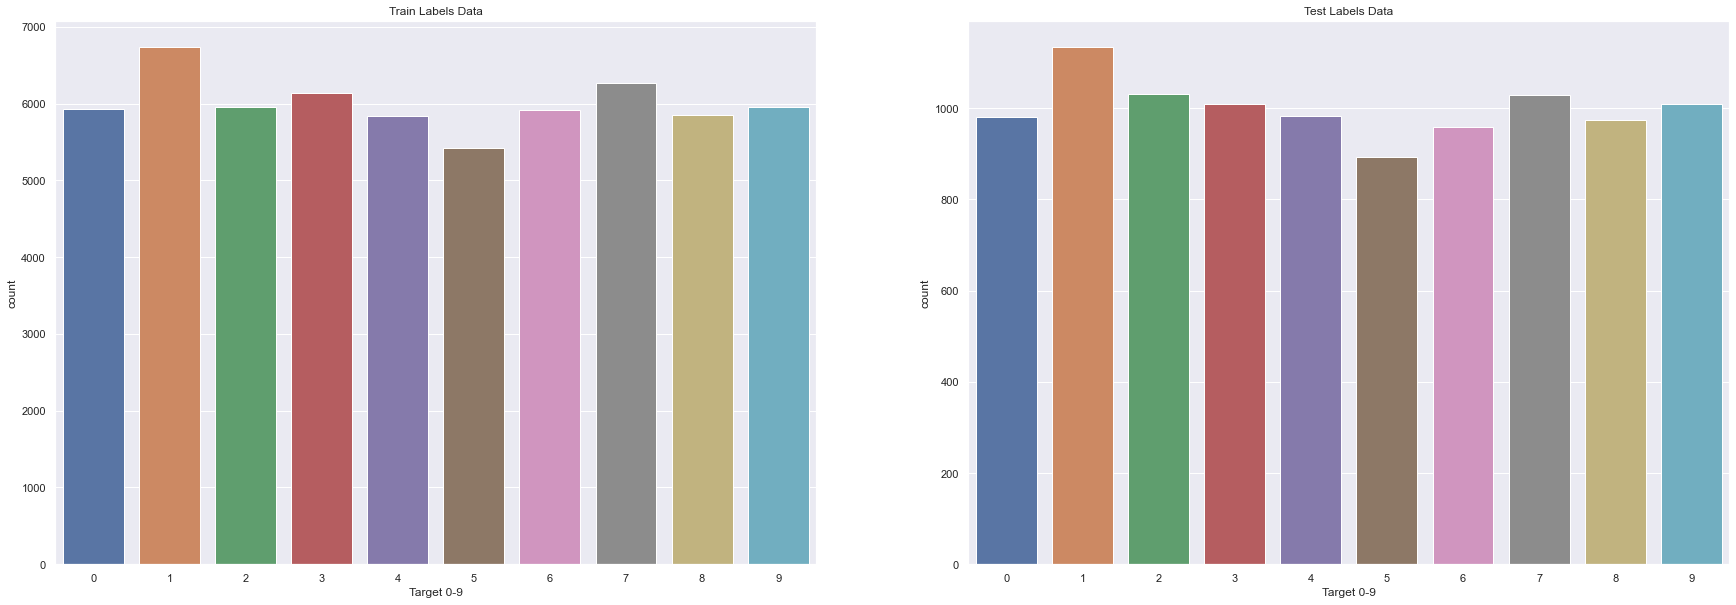

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(30,10))
sns.countplot(x=train_mnist_labels, ax=ax[0]).set(title="Train Labels Data", xlabel="Target 0-9")
sns.countplot(x=test_mnist_labels, ax=ax[1]).set(title="Test Labels Data", xlabel="Target 0-9")

In [5]:
x_mnist_train, x_mnist_valid, y_mnist_train, y_mnist_valid = train_test_split(train_mnist_images, train_mnist_labels, test_size=0.3) # random_state=221

In [6]:
def image_to_tensor_scale(img):
    output = tf.cast(img, tf.float32)
    output /= 255.
    return output

class data_generator(keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x = image_to_tensor_scale(x_set)
        self.y = y_set
        
        self.batch_size = batch_size
    
    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)
    
    def __getitem__(self, idx):
        idx_from = idx * self.batch_size
        idx_to = (idx + 1) * self.batch_size
        batch_x = self.x[idx_from:idx_to]
        batch_y = self.y[idx_from:idx_to]
        x = batch_x
        y = batch_y
        return np.array(x).astype(np.float32), np.array(y).astype(np.float32)

In [7]:
# DATAGEN เก็บข้อมูลจำนวน BATCH ตาม DATA / BATCH_SIZE ---> 420 TRAIN, 180 VALID WITH BATCH SIZE = 100
# ใน 1 BATCH ประกอบไปด้วย TUPLE ที่มี SHAPE เป็น (image, label)
# ใน image มีขนาด (100, 28, 28) ---> ตาม BATCH_SIZE
# ใน label มีขนาด (100,) ---> ตาม BATCH_SIZE
train_datagen = data_generator(x_set=x_mnist_train, y_set=y_mnist_train, batch_size=100)
valid_datagen = data_generator(x_set=x_mnist_valid, y_set=y_mnist_valid, batch_size=100)

In [8]:
def build_model(num_classes, input_shape):
    model = keras.Sequential()
    model.add(keras.Input(shape=input_shape))
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding="same", activation="relu",))
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding="same", activation="relu",))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu",))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu",))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation="relu"))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(num_classes, activation='softmax'))
    return model

In [9]:
ROWS = 28
COLUMNS = 28
BATCH_SIZE = 100
EPOCHS = 30
LEARNING_RATE = 0.001
optimizer = keras.optimizers.Adam(learning_rate = LEARNING_RATE)
loss_fn = keras.losses.SparseCategoricalCrossentropy()
acc_metric = keras.metrics.SparseCategoricalAccuracy()

MODEL_PATH = "models"
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
train_size = x_mnist_train.shape[0]
validation_size = x_mnist_valid.shape[0]
steps_per_epoch = train_size//BATCH_SIZE

checkpoint_filepath = os.path.join(MODEL_PATH, 'model.{epoch:02d}-{val_sparse_categorical_accuracy:.2f}-{val_loss:.2f}.h5')

checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                    save_weights_only=False,
                                                    monitor='val_sparse_categorical_accuracy',
                                                    mode='max',
                                                    save_best_only=True,
                                                    verbose=1)

reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                                    patience=3, min_lr=1e-5, vebose=1)

earlystop_callback = keras.callbacks.EarlyStopping(monitor="val_loss",
                                                min_delta=1e-3,
                                                patience=5,
                                                verbose=1)

In [10]:
tf.keras.backend.clear_session()
model = build_model(10, (ROWS, COLUMNS, 1))
model.compile(optimizer=optimizer, loss=loss_fn, metrics=[acc_metric])   
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                        

In [12]:
history = model.fit(train_datagen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=EPOCHS,
                    validation_data=valid_datagen,
                    validation_steps=validation_size//BATCH_SIZE,
                    callbacks=[earlystop_callback, reduce_lr_callback, checkpoint_callback],
                    verbose=2)

Epoch 1/30

Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.98306, saving model to models\model.01-0.98-0.06.h5
420/420 - 7s - loss: 0.2495 - sparse_categorical_accuracy: 0.9202 - val_loss: 0.0576 - val_sparse_categorical_accuracy: 0.9831 - lr: 0.0010 - 7s/epoch - 18ms/step
Epoch 2/30

Epoch 2: val_sparse_categorical_accuracy improved from 0.98306 to 0.98733, saving model to models\model.02-0.99-0.05.h5
420/420 - 6s - loss: 0.0770 - sparse_categorical_accuracy: 0.9773 - val_loss: 0.0465 - val_sparse_categorical_accuracy: 0.9873 - lr: 0.0010 - 6s/epoch - 13ms/step
Epoch 3/30

Epoch 3: val_sparse_categorical_accuracy did not improve from 0.98733
420/420 - 5s - loss: 0.0572 - sparse_categorical_accuracy: 0.9821 - val_loss: 0.0487 - val_sparse_categorical_accuracy: 0.9857 - lr: 0.0010 - 5s/epoch - 13ms/step
Epoch 4/30

Epoch 4: val_sparse_categorical_accuracy improved from 0.98733 to 0.99139, saving model to models\model.04-0.99-0.03.h5
420/420 - 5s - loss: 0.0492 - sparse

[Text(0.5, 1.0, 'Training & Validation Accuracy'),
 Text(0.5, 0, 'Epochs'),
 Text(0, 0.5, 'Accuracy')]

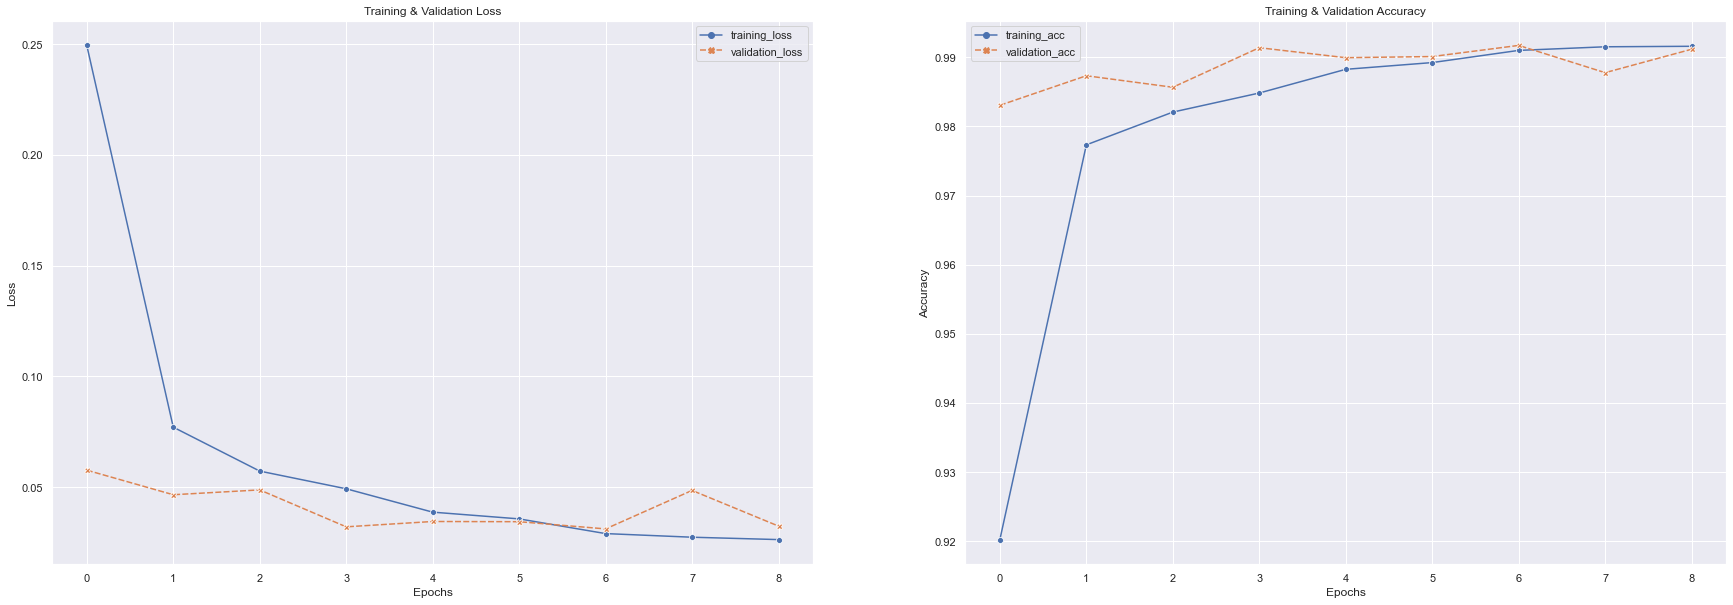

In [13]:
loss_result = pd.DataFrame({
    "training_loss": history.history['loss'],
    "validation_loss": history.history['val_loss']
})
acc_result = pd.DataFrame({
    "training_acc": history.history['sparse_categorical_accuracy'],
    "validation_acc": history.history['val_sparse_categorical_accuracy']
})

fig1, ax1 = plt.subplots(1, 2, figsize=(30,10))
sns.lineplot(data=loss_result, markers=True, ax=ax1[0]).set(title="Training & Validation Loss", xlabel="Epochs", ylabel="Loss")
sns.lineplot(data=acc_result, markers=True, ax=ax1[1]).set(title="Training & Validation Accuracy", xlabel="Epochs", ylabel="Accuracy")

### TEST MODEL

In [14]:
test_mnist_images_scale = image_to_tensor_scale(test_mnist_images)

In [16]:
test_loss, test_accuracy = model.evaluate(test_mnist_images_scale, test_mnist_labels)
print(f"LOSS ERROR: {test_loss*100:.3f}% | ACCURACY: {test_accuracy*100:.3f}%")

313/313 [==============================] - 1s 4ms/step - loss: 0.0220 - sparse_categorical_accuracy: 0.9935
LOSS ERROR: 2.197% | ACCURACY: 99.350%


#### CONFUSION MATRIX ON TEST DATA

In [17]:
test_predicted = model.predict(test_mnist_images_scale)
test_predicted = np.argmax(test_predicted, axis = 1) 

313/313 [==============================] - 1s 2ms/step


In [18]:
test_confusion = confusion_matrix(test_mnist_labels, test_predicted)
display(test_confusion)

array([[ 978,    0,    0,    0,    0,    1,    0,    1,    0,    0],
       [   0, 1132,    1,    1,    0,    0,    0,    1,    0,    0],
       [   1,    0, 1029,    0,    0,    0,    0,    2,    0,    0],
       [   0,    0,    0, 1009,    0,    1,    0,    0,    0,    0],
       [   0,    0,    1,    0,  973,    0,    0,    0,    0,    8],
       [   0,    0,    0,    4,    0,  886,    1,    1,    0,    0],
       [   4,    3,    0,    0,    3,    5,  940,    0,    3,    0],
       [   0,    2,    4,    0,    0,    0,    0, 1020,    1,    1],
       [   1,    0,    2,    1,    0,    1,    0,    0,  966,    3],
       [   0,    0,    0,    0,    2,    2,    0,    2,    1, 1002]],
      dtype=int64)

#### ERROR EXAMPLE

In [19]:
errors_examples = (test_predicted - test_mnist_labels != 0)
errors_indexes = []
for idx, error in enumerate(errors_examples):
    if error:
        errors_indexes.append(idx)
display("Number of Digit Errors in Test Dataset: ",len(errors_indexes))

'Number of Digit Errors in Test Dataset: '

65

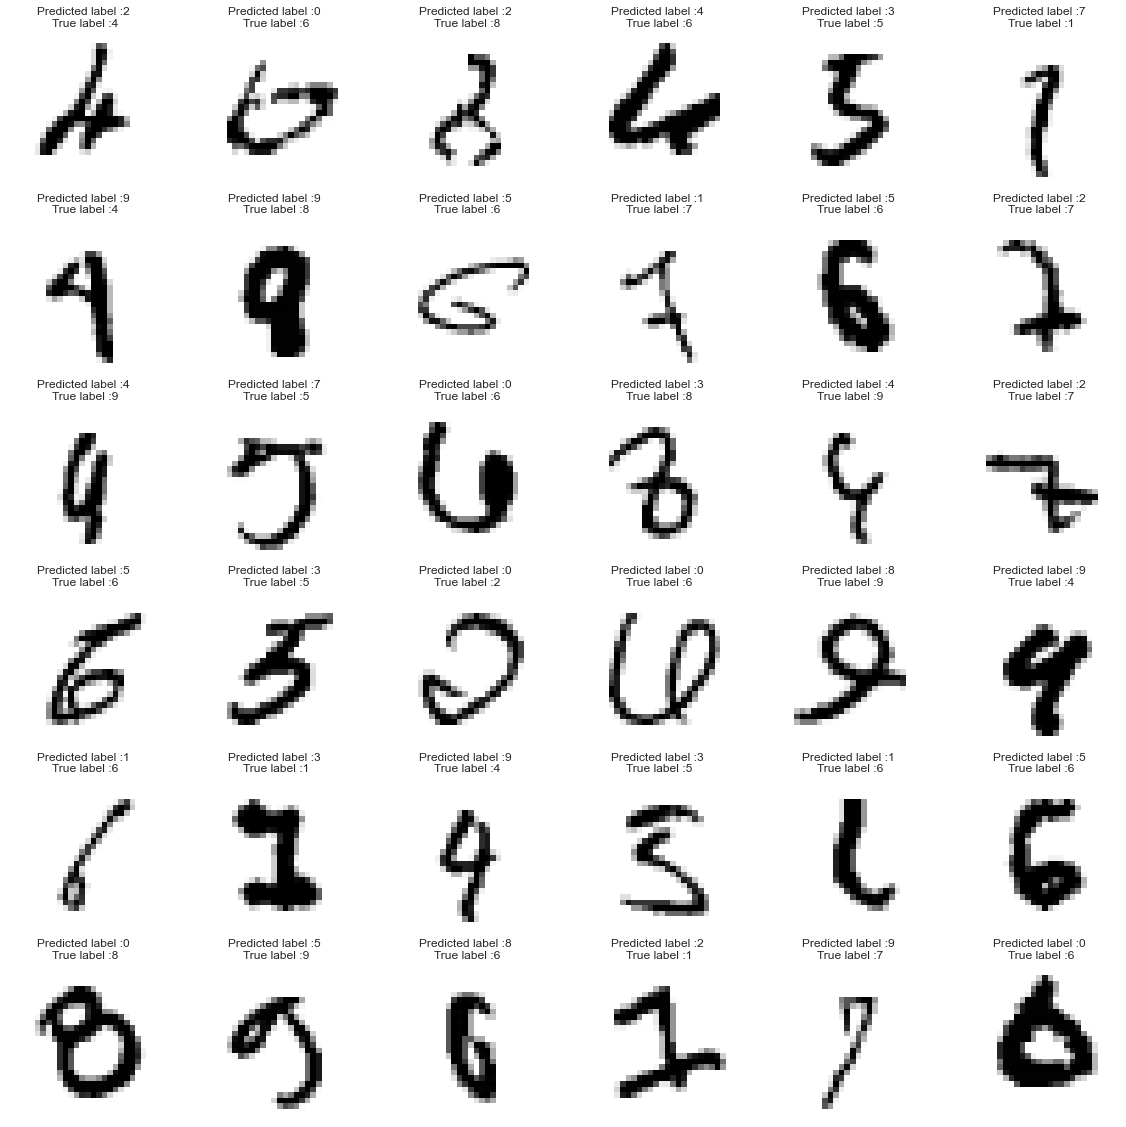

In [20]:
fig2, ax2 = plt.subplots(6, 6, figsize=(20,20))
for index, subplot in zip(errors_indexes, ax2.flatten()):
        subplot.imshow(test_mnist_images[index], cmap='binary')
        subplot.set_title(f"Predicted label :{test_predicted[index]} \nTrue label :{test_mnist_labels[index]}")
        subplot.axis('off')